Morgan Turville-Heitz
CS 760
11/1/2023

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from numpy import linalg as LA
import matplotlib.pyplot as plt


Generating synthetic datasets 
$$
P_a = \mathcal{N}\left( \begin{bmatrix} -1 \\ -1 \end{bmatrix}, \; \sigma\begin{bmatrix} 2 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right), 

P_b = \mathcal{N}\left( \begin{bmatrix} 1 \\ -1 \end{bmatrix}, \; \sigma\begin{bmatrix} 1 & -0.5 \\ -0.5 & 2 \end{bmatrix} \right), 

P_c = \mathcal{N}\left( \begin{bmatrix} 0 \\ 1 \end{bmatrix}, \; \sigma\begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix} \right) 
$$

In [3]:
gaussian_parameters = {
    'a': {'mean': np.array([-1, -1]), 'cov': np.array([[2, 0.5], [0.5, 1]])},
    'b': {'mean': np.array([1, -1]), 'cov': np.array([[1, -0.5], [-0.5, 2]])},
    'c': {'mean': np.array([0, 1]), 'cov': np.array([[1, 0], [0, 2]])}
}

Sigma = [0.5, 1, 2, 4, 8]

In [4]:
### Generating data X_J

N_ = 100
X_J = {str(sigma): {set_key: [[],[]] for set_key in 'abc'} for sigma in Sigma}
for sigma in X_J.keys():
    print(f"Generating dataset for {sigma}")
    for set in X_J[sigma].keys():
        covariance = float(sigma) * gaussian_parameters[set]['cov']
        distribution = multivariate_normal(mean = gaussian_parameters[set]['mean'], cov = covariance)
        X_J[str(sigma)][set][0] = distribution.rvs(size=N_)
        X_J[str(sigma)][set][1] = ['i'] * N_
        print(f"Shape of sample points: {X_J[str(sigma)][set][0].shape}, Length of 'i' array: {len(X_J[str(sigma)][set][1])}")


Generating dataset for 0.5
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Generating dataset for 1
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Generating dataset for 2
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Generating dataset for 4
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Generating dataset for 8
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i' array: 100
Shape of sample points: (100, 2), Length of 'i'

<ipython-input-14-84fb37ecaf9c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


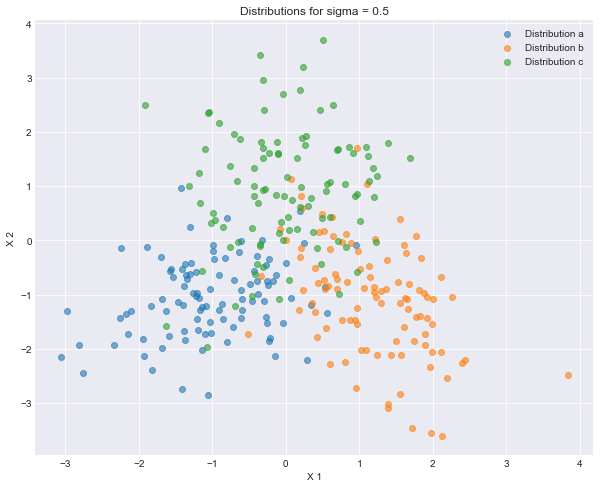

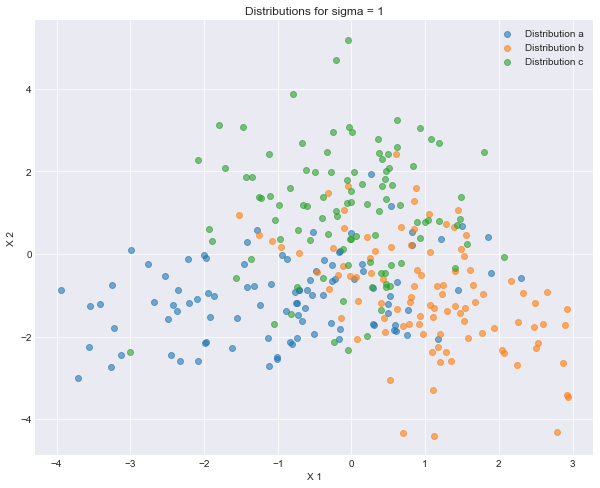

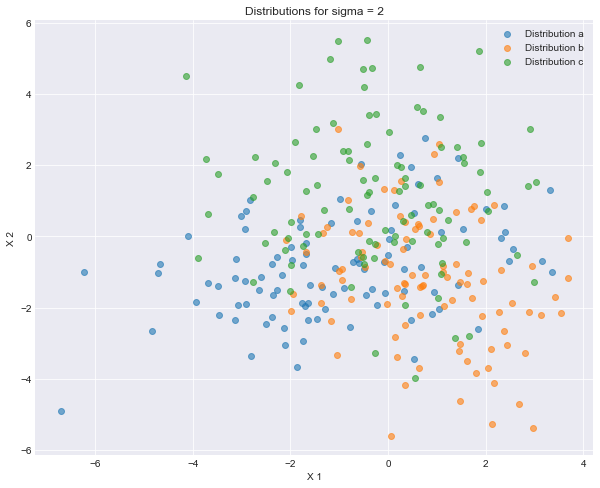

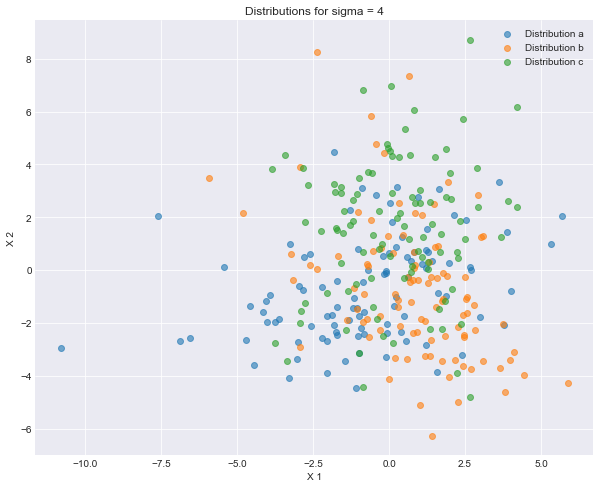

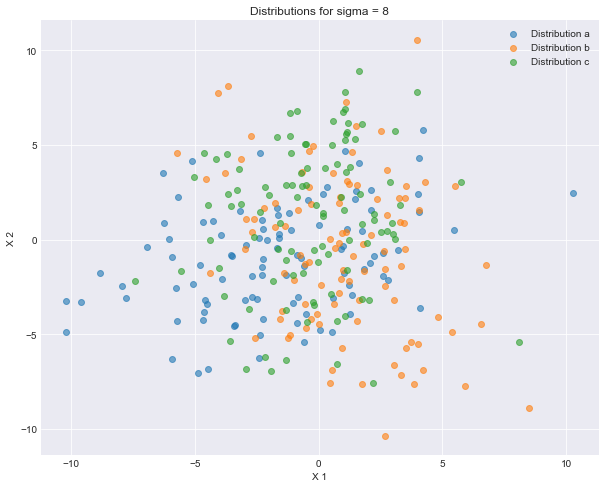

In [14]:
plt.style.use('seaborn-darkgrid')

for sigma in Sigma:
    plt.figure(figsize=(10, 8))  
    plt.title(f'Distributions for sigma = {sigma}')
    plt.xlabel('X 1')
    plt.ylabel('X 2')

    for set_key in 'abc':
        samples = X_J[str(sigma)][set_key][0]
        
        x, y = samples[:, 0], samples[:, 1]
        
        plt.scatter(x, y, label=f'Distribution {set_key}', alpha=0.6)

    plt.legend()
    plt.show()


K-Means++ Implementation - Our objective is:
$$J(\mu_1^K, f; X_1^n) = \sum_{i=1}^n \sum_{k=1}^K \mathbb{1} (f(X_i) = k) \|X_i - \mu_k\|^2$$

In [ ]:
### K-Means++ Algorithm


### Begin with 150 iterations
### Never hits this - usually halts ~20
iterations = 150

Cj = {}

### Implementing K-means++
for sigma in Sigma:
    X_data = []
    for k in X_J[str(sigma)].keys():
        X_data.extend(X_J[str(sigma)][k][0])
    X_data = np.array(X_data)  

    c1_index = np.random.choice(range(len(X_data)))
    c1 = X_data[c1_index]

    distances = np.array([np.linalg.norm(x - c1)**2 for x in X_data])
    probabilities = distances / distances.sum()
    cumulative_probabilities = probabilities.cumsum()
    r = np.random.rand()
    c2_index = np.where(cumulative_probabilities >= r)[0][0]
    c2 = X_data[c2_index]

    distances = np.array([min(np.linalg.norm(x - c)**2 for c in [c1, c2]) for x in X_data])
    probabilities = distances / distances.sum()
    cumulative_probabilities = probabilities.cumsum()
    r = np.random.rand()
    c3_index = np.where(cumulative_probabilities >= r)[0][0]
    c3 = X_data[c3_index]
    Cj[str(sigma)] = {'1': c1, '2': c2, '3': c3}

### Initialize the cluster centers for each sigma
norms = {'a': gaussian_parameters['a']['mean'], 'b': gaussian_parameters['b']['mean'], 'c': gaussian_parameters['c']['mean']}

corrects = {sigma: {'a' : [], 'b' : [], 'c' : []} for sigma in Cj.keys()}
incorrects = {sigma: {'a' : [], 'b' : [], 'c' : []} for sigma in Cj.keys()}
objective = {sigma: [] for sigma in Cj.keys()}

for sigma in Cj.keys():
    for i in range(1, iterations + 1):
        change = False
        obj = 0

        for set in Cj[sigma].keys():
            for xset in X_J[str(sigma)].keys():
                for j, xi in enumerate(X_J[str(sigma)][xset][0]):
                    pre = X_J[str(sigma)][xset][1][j]
                    euclidean = {k: LA.norm(xi - Cj[sigma][k]) for k in Cj[sigma].keys()}
                    pred = min(euclidean, key=euclidean.get) 
                    X_J[str(sigma)][xset][1][j] = pred
                    if pre != pred:
                        change = True

        for set in Cj[sigma].keys():
            sum_ = np.array([0.0, 0.0])
            N = 0
            for xset in X_J[str(sigma)].keys():
                for l, xi in enumerate(X_J[str(sigma)][xset][0]):
                    if X_J[str(sigma)][xset][1][l] == set:
                        sum_ += xi
                        N += 1
            if N > 0:
                Cj[sigma][set] = sum_ / N 
            else:
                print("No points assigned to cluster {set}")
    

        mapping = {'a':1, 'b': 2, 'c': 3}

        for key in norms.keys():
            dist_to_mean = {k: LA.norm(norms[key] - Cj[sigma][k]) for k in Cj[sigma].keys()}
            minim = min(dist_to_mean, key=dist_to_mean.get)
            mapping[key] = minim

        for xset in X_J[str(sigma)].keys():
            cor = 0
            inc = 0
            for i, xi in enumerate(X_J[str(sigma)][xset][0]):
                
                pred = X_J[str(sigma)][xset][1][i]
                if str(mapping[xset]) == str(pred):
                    cor +=1
                else: 
                    inc +=1
                
                ### Instead of searching through all sums O(N^2), just iterate over all xi, and add to the objective (error)
                ### function the value of (xi - cj) for f(xi) = cj
                obj += LA.norm(xi - Cj[sigma][pred]) ** 2

            corrects[str(sigma)][xset].append(cor)
            incorrects[str(sigma)][xset].append(inc)    
        objective[str(sigma)].append(obj)
        if not change:
            print("Stopped early")
            break   

for sigma in Cj.keys():
    print(f"For sigma = {sigma}")
    print(f"Correct: {corrects[sigma]}")
    print(f"Incorrect: {incorrects[sigma]}")
    print(f"Objective is {objective[sigma]}")
    print()

km_corrects = corrects
km_incorrects = incorrects
km_objective = objective


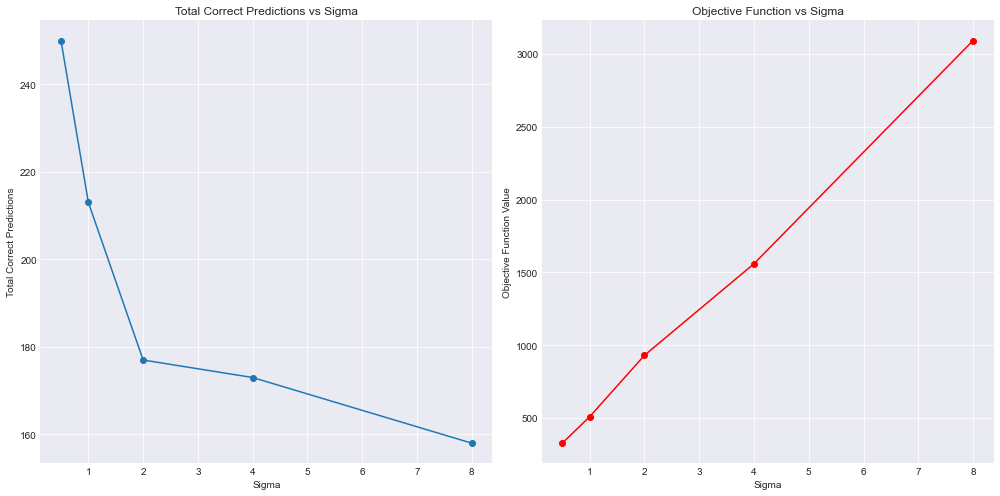

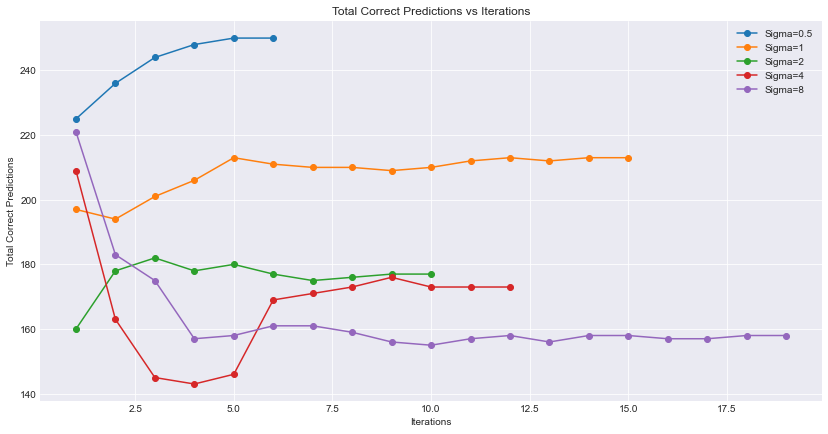

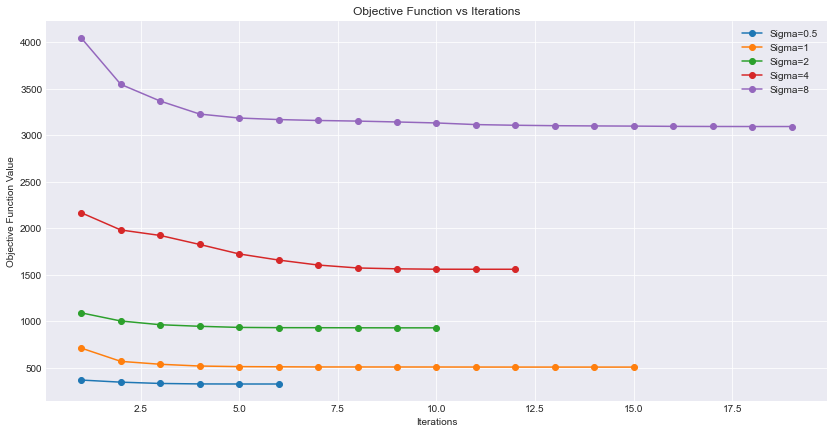

In [7]:
def plot_kmeans_results(km_corrects, km_objective, Sigma):
    total_corrects_vs_sigma = [sum([km_corrects[str(sigma)][k][-1] for k in 'abc']) for sigma in Sigma]
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(Sigma, total_corrects_vs_sigma, marker='o')
    plt.xlabel('Sigma')
    plt.ylabel('Total Correct Predictions')
    plt.title('Total Correct Predictions vs Sigma')
    
    objective_vs_sigma = [km_objective[str(sigma)][-1] for sigma in Sigma]
    plt.subplot(1, 2, 2)
    plt.plot(Sigma, objective_vs_sigma, marker='o', color='red')
    plt.xlabel('Sigma')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function vs Sigma')
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    for sigma in Sigma:
        total_corrects_vs_iterations = [sum([km_corrects[str(sigma)][k][i] for k in 'abc']) for i in range(len(km_corrects[str(sigma)]['a']))]
        plt.plot(range(1, len(total_corrects_vs_iterations) + 1), total_corrects_vs_iterations, marker='o', label=f'Sigma={sigma}')
    
    plt.xlabel('Iterations')
    plt.ylabel('Total Correct Predictions')
    plt.title('Total Correct Predictions vs Iterations')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 7))
    for sigma in Sigma:
        plt.plot(range(1, len(km_objective[str(sigma)]) + 1), km_objective[str(sigma)], marker='o', label=f'Sigma={sigma}')
    
    plt.xlabel('Iterations')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function vs Iterations')
    plt.legend()
    plt.show()

plot_kmeans_results(km_corrects, km_objective, Sigma)

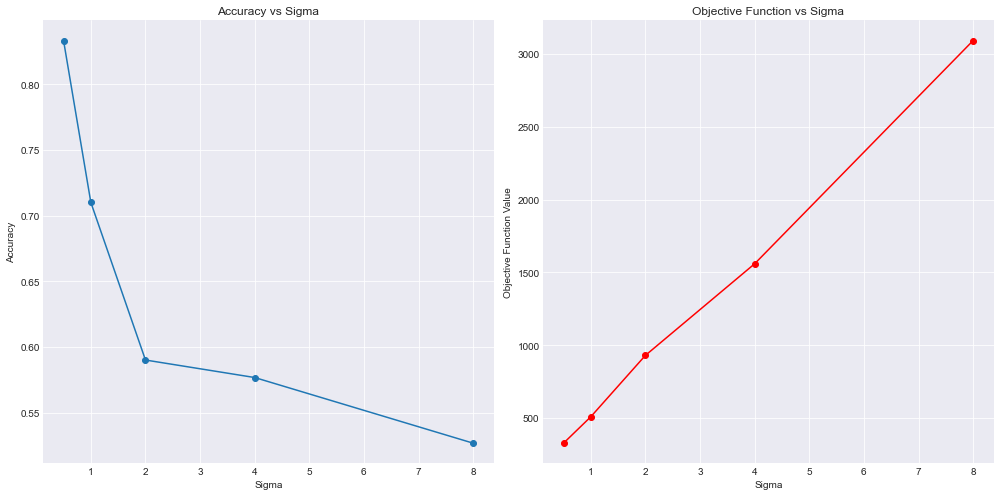

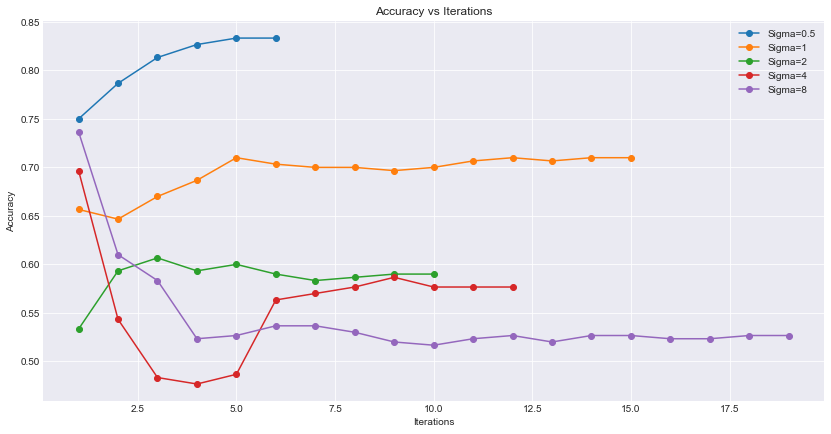

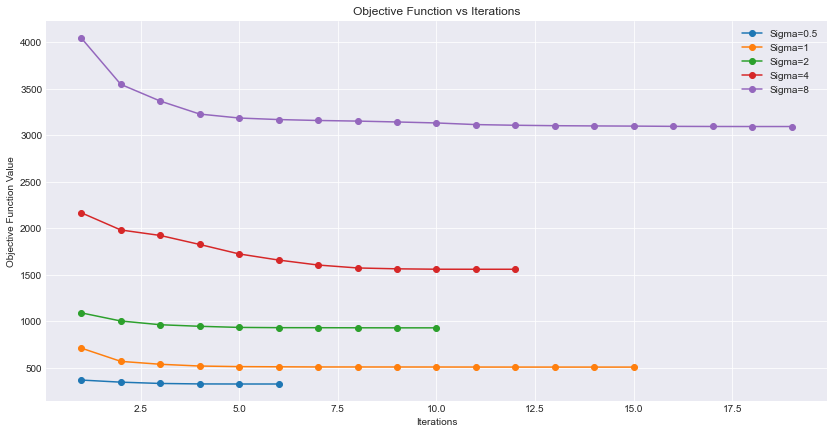

In [8]:
def plot_kmeans_results(km_corrects, km_objective, Sigma):
    accuracies_vs_sigma = {str(sigma): {k: [correct / 300 for correct in km_corrects[str(sigma)][k]] for k in 'abc'} for sigma in Sigma}

    accuracy_vs_sigma = [sum([accuracies_vs_sigma[str(sigma)][k][-1] for k in 'abc']) for sigma in Sigma]
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(Sigma, accuracy_vs_sigma, marker='o')
    plt.xlabel('Sigma')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Sigma')
    
    objective_vs_sigma = [km_objective[str(sigma)][-1] for sigma in Sigma]
    plt.subplot(1, 2, 2)
    plt.plot(Sigma, objective_vs_sigma, marker='o', color='red')
    plt.xlabel('Sigma')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function vs Sigma')
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    for sigma in Sigma:
        accuracy_vs_iterations = [sum([accuracies_vs_sigma[str(sigma)][k][i] for k in 'abc']) for i in range(len(accuracies_vs_sigma[str(sigma)]['a']))]
        plt.plot(range(1, len(accuracy_vs_iterations) + 1), accuracy_vs_iterations, marker='o', label=f'Sigma={sigma}')
    
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Iterations')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 7))
    for sigma in Sigma:
        plt.plot(range(1, len(km_objective[str(sigma)]) + 1), km_objective[str(sigma)], marker='o', label=f'Sigma={sigma}')
    
    plt.xlabel('Iterations')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function vs Iterations')
    plt.legend()
    plt.show()

plot_kmeans_results(km_corrects, km_objective, Sigma)


GMM Implementation - Our objective is:
$$\mathcal{L}(\theta|\mathbf{X}) = - \sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} p_{\theta} (x_{i}, z_{i} = j) \right)
$$

$$\mathcal{L}(\theta|\mathbf{X}) = - \sum_{i=1}^{N}  \sum_{k=1}^{K}  Q_{j}^{(i)} \log \left( \frac{p_{\theta} (x_{i}, z_{i} = j)}{Q_{j}^{(i)}}  \right)
$$

Algorithm:

E Update $$ Q_{j}^{(i)} \leftarrow p_{\theta_{t}}(z_{i} = j | x_{i}) $$
M Update $$ \theta_{t+1} \leftarrow \argmax_{\theta} \sum_{i=1}^{N}  \sum_{k=1}^{K} Q_{j}^{(i)} \log \left( \frac{p_{\theta} (x_{i}, z_{i} = j)}{Q_{j}^{(i)}}  \right) $$

Using a density function for the calc

In [9]:
def density(x, mu, cov):

    det = np.linalg.det(cov)
    norm = 1.0 / (np.power((2 * np.pi), float(len(x)) / 2) * np.power(det, 1.0 / 2))
    x_mu = x - mu
    inv = np.linalg.inv(cov)
    result = np.exp(-0.5 * (np.dot(np.dot(x_mu, inv), x_mu)))
    return norm * result

In [10]:
def calculate_nll(X_J, phi, mus, sigs, sigma):
    nll = 0
    for set_key in 'abc':
        for x in X_J[str(sigma)][set_key][0]:
            likelihoods = []
            for j in range(3):
                component_density = density(x, mus[str(sigma)][j], sigs[str(sigma)][j])
                likelihoods.append(phi[j] * component_density)
            total_likelihood = sum(likelihoods)
            nll -= np.log(total_likelihood + 1e-8) 
    return nll

In [ ]:
### Gaussian Mixture Model Algorithm

### USING MAPPING - MEAN DISTANCE BETWEEN TRUE LABEL MEAN AND GMM MEANS

### For ensuring positive semi-definite cov matrix
epsilon = 1e-6  

### Getting terrible results if I initialize priors randomly
phi_i = np.array([1/3, 1/3, 1/3])

### Initializing means ith randomly selected datapoints for each k, analogous to kmeans++
mus_i = {}
for sig_value in Sigma:
    mus_i[str(sig_value)] = []
    for k in 'abc':
        random_indices = np.random.choice(len(X_J[str(sig_value)][k][0]), size=3, replace=False)
        mus_i[str(sig_value)].extend(X_J[str(sig_value)][k][0][random_indices])

### Initialized based on variance of the generated data (is this data leakage? I can't get good results without messing around with this initialization)
sig_i = {}
for sig_value in Sigma:
    data_combined = np.concatenate([X_J[str(sig_value)][k][0] for k in 'abc'], axis=0)
    overall_cov = np.cov(data_combined.T)
    avg_var = np.mean(np.diag(overall_cov))
    sig_i[str(sig_value)] = [np.eye(data_combined.shape[1]) * avg_var for _ in range(3)]


nll = {str(sigma): [] for sigma in Sigma}
norm_nll = {str(sigma): [] for sigma in Sigma}

cor_gmm = {str(sigma): {key : [] for key in ['a','b','c']} for sigma in Sigma}
inc_gmm = {str(sigma): {key : [] for key in ['a','b','c']} for sigma in Sigma}

norms = {'a': gaussian_parameters['a']['mean'], 'b': gaussian_parameters['b']['mean'], 'c': gaussian_parameters['c']['mean']}

stopping = 1e-6

iterations = 40
for sigma in Sigma:

    phi = phi_i
    sig = sig_i
    mus = mus_i

    X = np.concatenate([X_J[str(sigma)][set][0] for set in 'abc'])
    true_labels = np.concatenate([[set] * len(X_J[str(sigma)][set][0]) for set in 'abc'])  
    unique_labels, counts = np.unique(true_labels, return_counts=True)
    print(f"Labels and their counts for sigma={sigma}: {dict(zip(unique_labels, counts))}")
    Q = np.zeros((len(X), 3))

    prev_nll = None  

    for n in range(iterations):

        for i, x in enumerate(X):

            for j in range(3):
                Q[i, j] = phi[j] * density(x, mus[str(sigma)][j], sig[str(sigma)][j])
            Q[i, :] /= np.sum(Q[i, :]) if np.sum(Q[i, :]) > epsilon else 1


        phi = np.sum(Q, axis=0) / len(X)
        for j in range(3):
            Q_sum_j = np.sum(Q[:, j])
            if Q_sum_j > epsilon:
                mus[str(sigma)][j] = np.dot(Q[:, j], X) / Q_sum_j
                diff = X - mus[str(sigma)][j]
                sig[str(sigma)][j] = np.dot(Q[:, j] * diff.T, diff) / Q_sum_j
                sig[str(sigma)][j] += epsilon * np.eye(X.shape[1])
            else:
                mus[str(sigma)][j] = np.zeros(X.shape[1])
                sig[str(sigma)][j] = np.eye(X.shape[1])

        current_nll = calculate_nll(X_J, phi, mus, sig, sigma)
        nll[str(sigma)].append(current_nll)
        norm_nll[str(sigma)].append(current_nll / len(X))


        mapping = {'a': 0, 'b': 1, 'c': 2}

        for key in norms.keys():
            dist_to_mean = {k: LA.norm(norms[key] - mus[str(sigma)][k]) for k in range(3)}
            minim = min(dist_to_mean, key=dist_to_mean.get)
            mapping[key] = minim
        r = {v: k for k, v in mapping.items()}
        pre = np.array([np.argmax(row) for row in Q])
        predicted = np.vectorize(r.get)(pre)

        for key in 'abc':
                
                true_ind = np.where(true_labels == key)[0]
                predicted_for_key = predicted[true_ind]
                correct_count = np.count_nonzero(predicted_for_key == key)
                incorrect_count = len(predicted_for_key) - correct_count

                cor_gmm[str(sigma)][key].append(correct_count)
                inc_gmm[str(sigma)][key].append(incorrect_count)


        if prev_nll is not None and abs(prev_nll - current_nll) < stopping:
            print(f"Change in NLL is below threshold for sigma={sigma} at iteration {n+1}.")
            ### Removed stopping condition since the NLL may decrease/increase after flattening out at a saddle point
        prev_nll = current_nll
        print(f"Correct count for sigma={sigma} at iteration {n+1}: {[cor_gmm[str(sigma)][key][n] for key in 'abc']}")
        print(f"Iteration {n} for sigma = {sigma} has negative log likelihood {nll[str(sigma)][n]}")



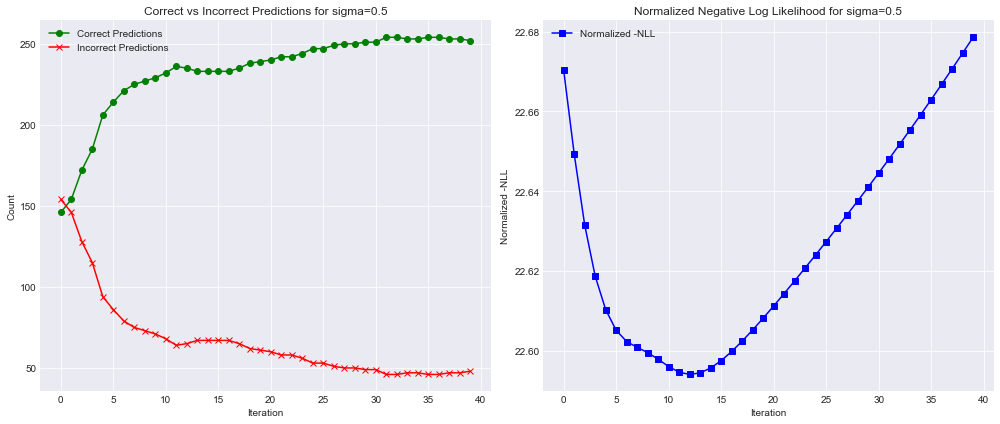

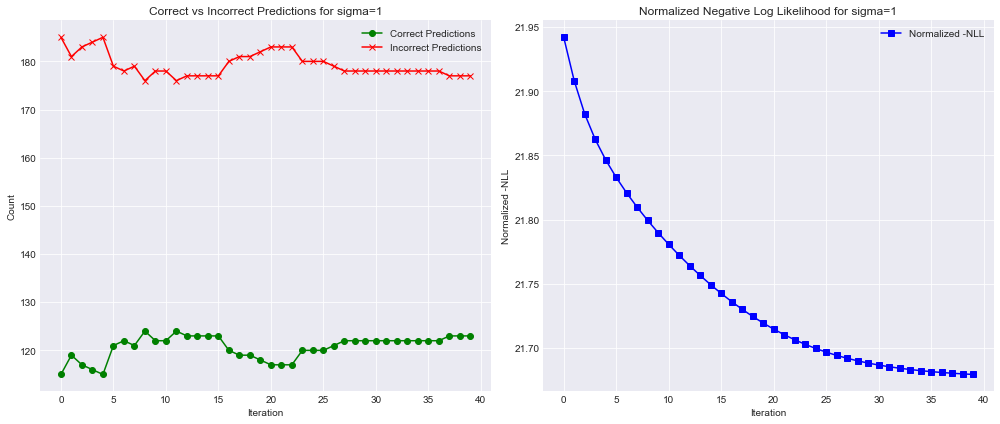

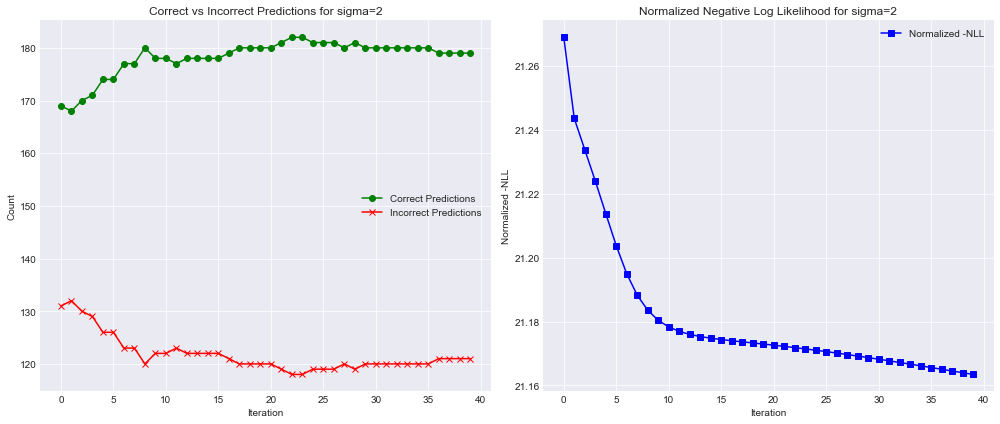

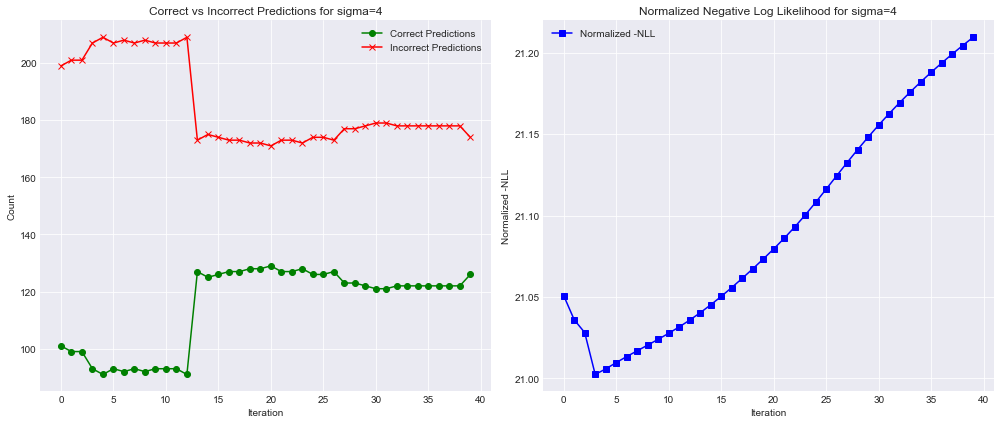

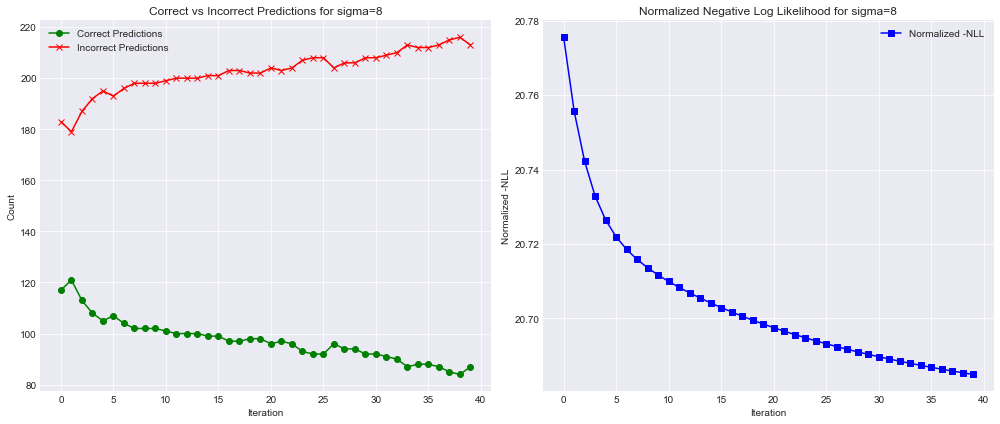

In [12]:
iterations = range(len(next(iter(nll.values()))))

for sigma in Sigma:
    correct_counts = [np.sum([cor_gmm[str(sigma)][key][i] for key in 'abc']) for i in iterations]
    incorrect_counts = [np.sum([inc_gmm[str(sigma)][key][i] for key in 'abc']) for i in iterations]
    normalized_nll_values = norm_nll[str(sigma)]

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(iterations, correct_counts, label='Correct Predictions', color='green', marker='o')
    plt.plot(iterations, incorrect_counts, label='Incorrect Predictions', color='red', marker='x')
    plt.title(f'Correct vs Incorrect Predictions for sigma={sigma}')
    plt.xlabel('Iteration')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iterations, normalized_nll_values, label='Normalized -NLL', color='blue', marker='s')
    plt.title(f'Normalized Negative Log Likelihood for sigma={sigma}')
    plt.xlabel('Iteration')
    plt.ylabel('Normalized -NLL')
    plt.legend()

    plt.tight_layout()
    plt.show()

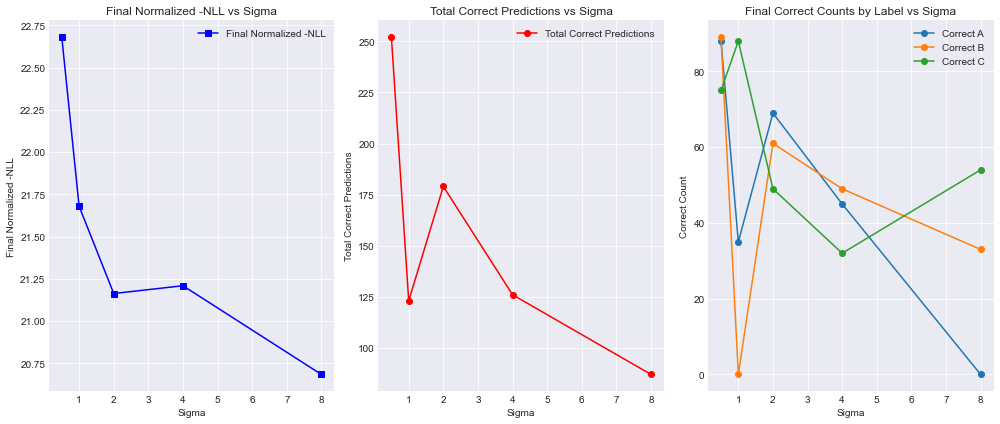

In [13]:

total_correct_predictions = {str(sigma): sum(cor_gmm[str(sigma)][key][-1] for key in 'abc') for sigma in Sigma}
final_correct_counts = {key: [cor_gmm[str(sigma)][key][-1] for sigma in Sigma] for key in 'abc'}
final_normalized_nll = [norm_nll[str(sigma)][-1] for sigma in Sigma]

plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(Sigma, final_normalized_nll, label='Final Normalized -NLL', color='blue', marker='s')
plt.title('Final Normalized -NLL vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Final Normalized -NLL')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(Sigma, list(total_correct_predictions.values()), label='Total Correct Predictions', color='red', marker='o')
plt.title('Total Correct Predictions vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Total Correct Predictions')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
for key in 'abc':
    plt.plot(Sigma, final_correct_counts[key], label=f'Correct {key.upper()}', marker='o')
plt.title('Final Correct Counts by Label vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Correct Count')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

